In [1]:

from google.colab import drive
import sys
drive.mount('/content/drive')

# Add necessary directories to sys.path
sys.path.append('/content/drive/My Drive/AbelBioToken-main/AbelBioToken-main/data')
sys.path.append('/content/drive/My Drive/AbelBioToken-main/AbelBioToken-main/model')
sys.path.append('/content/drive/My Drive/AbelBioToken-main/AbelBioToken-main/train')
sys.path.append('/content/drive/My Drive/AbelBioToken-main/AbelBioToken-main/test')


Mounted at /content/drive


2.4.1+cu121
Using device: cpu
Epoch 1/4, Train Loss: 2.7801, Train Acc: 0.5286, Validation Loss: 2.3729, Validation Acc: 0.9267
Epoch 2/4, Train Loss: 2.3192, Train Acc: 0.9840, Validation Loss: 2.2854, Validation Acc: 1.0000
Epoch 3/4, Train Loss: 2.2881, Train Acc: 1.0000, Validation Loss: 2.2854, Validation Acc: 1.0000
Epoch 4/4, Train Loss: 2.2872, Train Acc: 1.0000, Validation Loss: 2.2854, Validation Acc: 1.0000


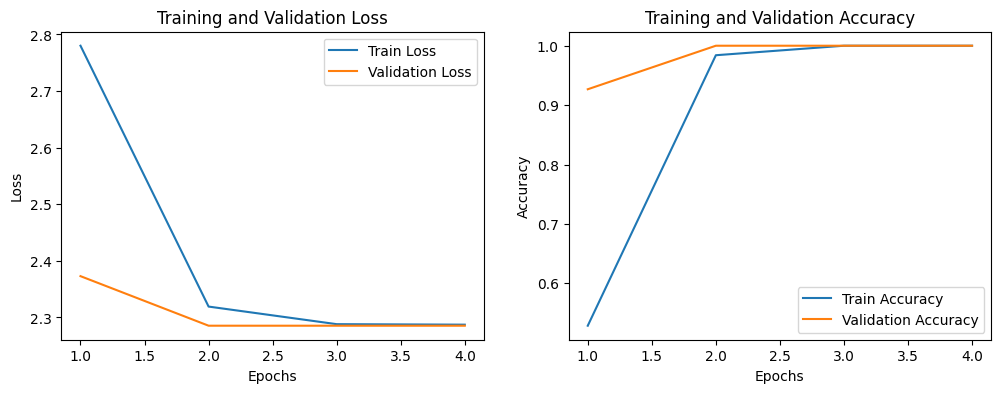

In [2]:
import context
import os
import torch
import torch.nn as nn # tensor and neural network computations
import torch.optim as optim
import matplotlib.pyplot as plt


from model.transformer import Transformer
from train.dataset import get_dataloader, DataCtg


train_dataloader, lab_len, tok_len = get_dataloader(DataCtg.TRAIN, 32)
val_dataloader, _, _ = get_dataloader(DataCtg.VAL, 32) # batches of data for training and validation

src_vocab_size = 1404 # number of unique tokens
target_vocab_size = 25
target_padding = 24  # the padding char in target
num_layers = 6 # layers in transformer model


# Initialise model - not used in final
class TransformerWithDropout(Transformer):
    def __init__(self, *args, **kwargs):
        super(TransformerWithDropout, self).__init__(*args, **kwargs)
        self.dropout = nn.Dropout(0.5)

    def forward(self, src, trg):
        src = self.dropout(src)
        trg = self.dropout(trg)
        return super(TransformerWithDropout, self).forward(src, trg)


model = Transformer(
    embed_dim=512, # dimensions of embedding vectors
    src_vocab_size=src_vocab_size,
    target_vocab_size=target_vocab_size,
    src_seq_length=tok_len,
    trg_seq_length=lab_len,
    num_layers=num_layers,
    expansion_factor=4, # Factor for expanding dimensions in feed forward network - captures complex behaviour
    n_heads=8, # number of attention heads
)

model_path=os.path.join(context.current_dir, 'transformer_model.pth')

if os.path.exists(model_path):
    model = torch.load(model_path)

# Check if CUDA is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Transfers model parameters to cuda (GPU) or cpu
print(f"Using device: {device}")

model = model.to(device)

# Hyperparameters
batch_size = 32 # Number of samples processed before the model is updated.
learning_rate = 0.00004
num_epochs = 4
criterion = nn.CrossEntropyLoss(
    ignore_index=target_padding # Tells the loss function to ignore the padding tokens in the target sequences
)  # Assuming 24 is the padding index
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # optim.Adam: Adaptive Moment Estimation optimizer. weight_decay=1e-4: L2 regularization term to prevent overfitting.

# Track metrics These lists will store loss and accuracy values after each epoch for both training and validation datasets.
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Computes accuracy for variable-length sequences, considering padding.
def calculate_accuracy(predictions, targets):
    first_one_index = (targets == 1).nonzero(as_tuple=True)[1]
    mask = torch.arange(targets.size(1)).expand_as(targets) <= first_one_index.unsqueeze(1)
    _, preds = torch.max(predictions, dim=-1)
    correct = (preds == targets).float()
    correct = correct * mask.float()
    accuracy = correct.sum() / mask.sum()
    return accuracy.item()


# Training and validation loops
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, running_corrects, total = 0.0, 0, 0
    for label, token in train_dataloader:
        token, label = token.to(device), label.to(device, dtype=torch.long)
        optimizer.zero_grad()
        out = model(token, label)
        if hasattr(model, "src_mask"):
            model.src_mask = model.src_mask.to(device)
        if hasattr(model, "trg_mask"):
            model.trg_mask = model.trg_mask.to(device)

        loss = criterion(out.view(-1, out.size(-1)), label.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * token.size(0)
        running_corrects += calculate_accuracy(out, label) * token.size(0)
        total += token.size(0)
    train_loss = running_loss / total
    train_acc = running_corrects / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation. Similar to the training loop but without backpropagation and optimizer steps.
    model.eval() # Sets the model to evaluation mode (disables dropout, batch normalization, etc.
    val_running_loss, val_running_corrects, val_total = 0.0, 0, 0
    with torch.no_grad():
        for label, token in val_dataloader:
            token, label = token.to(device), label.to(device, dtype=torch.long)
            out = model(token, label)
            if hasattr(model, "src_mask"):
                model.src_mask = model.src_mask.to(device)
            if hasattr(model, "trg_mask"):
                model.trg_mask = model.trg_mask.to(device)

            loss = criterion(out.view(-1, out.size(-1)), label.view(-1))
            val_running_loss += loss.item() * token.size(0)
            val_running_corrects += calculate_accuracy(out, label) * token.size(0)
            val_total += token.size(0)
    val_loss = val_running_loss / val_total
    val_acc = val_running_corrects / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}"
    )

# Save the model
torch.save(model, "transformer_model.pth")

# Plotting the loss and accuracy graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()
